In [12]:
import sys
import copy

import torch
import gymnasium as gym
import matplotlib.pyplot as plt

sys.path.append("../")
from breakout.DQN import VisionDeepQ

In [43]:
environment = gym.make('ALE/Breakout-v5', render_mode="rgb_array",
                       obs_type="grayscale", frameskip=1, repeat_action_probability=0.0)
environment.metadata["render_fps"] = 30

GAMES = 10
SKIP = 6

SHAPE = {
    "original": (1, 1, 210, 160),
    "height": slice(31, -17),
    "width": slice(7, -7),
}

DISCOUNT = 0.95
GAMMA = 0.99
GRADIENTS = (-1, 1)

PUNISHMENT = 0
INCENTIVE = 1

MINIBATCH = 32
TRAIN_EVERY = 25

EXPLORATION_RATE = 1.0
EXPLORATION_MIN = 0.1
EXPLORATION_STEPS = 45000 // TRAIN_EVERY

MIN_REWARD = lambda game: 0#game / 500 if game <= 5000 else 10
MEMORY = 1500
RESET_Q_EVERY = TRAIN_EVERY * 5

NETWORK = {
    "input_channels": 1, "outputs": 4,
    "channels": [32, 64, 64],
    "kernels": [8, 4, 3],
    "padding": ["valid", "valid", "valid"],
    "strides": [4, 2, 1],
    "nodes": [512],
}
OPTIMIZER = {
    "optimizer": torch.optim.RMSprop,
    "lr": 0.00025,
    "hyperparameters": {"eps": 1e-6, "weight_decay": 0.99}
}

value_agent = VisionDeepQ(
    network=NETWORK, optimizer=OPTIMIZER, shape=SHAPE,

    batch_size=MINIBATCH, memory=MEMORY,

    discount=DISCOUNT, gamma=GAMMA,
    punishment=PUNISHMENT, incentive=INCENTIVE,

    exploration_rate=EXPLORATION_RATE,
    exploration_steps=EXPLORATION_STEPS,
    exploration_min=EXPLORATION_MIN,
)
_value_agent = copy.deepcopy(value_agent)

TRAINING = False
_STEPS = _LOSS = _REWARD = 0
for game in range(1, GAMES + 1):
    initial = value_agent.preprocess(environment.reset()[0])
    states = torch.cat([initial] * value_agent.shape["reshape"][1], dim=1)

    DONE = False
    STEPS = REWARDS = 0
    TRAINING = True if (not TRAINING and len(value_agent.memory["memory"]) > 0) else TRAINING
    while not DONE:
        action, new_states, rewards, DONE = value_agent.observe(environment, states, SKIP)
        value_agent.remember(states, action, torch.tensor(rewards))

        states = new_states
        REWARDS += rewards
        STEPS += 1

    if REWARDS >= MIN_REWARD(game):
        value_agent.memorize(states, STEPS)
    value_agent.memory["game"].clear()

    LOSS = None
    if game % TRAIN_EVERY == 0 and TRAINING:
        LOSS = value_agent.learn(network=_value_agent, clamp=GRADIENTS)
        EXPLORATION_RATE = value_agent.parameter["rate"]
        _LOSS += LOSS
    _REWARD += REWARDS
    _STEPS += STEPS

    if game % RESET_Q_EVERY == 0 and TRAINING:
        _value_agent.load_state_dict(value_agent.state_dict())

In [44]:
memory = value_agent.memory["memory"]

_steps = [game.steps for game in memory]
steps = [sum(_steps[:i + 1]) - 1 for i in range(len(_steps))]

states = torch.cat([torch.stack(game.state).squeeze(1) for game in memory])
actions = torch.cat([torch.stack(game.action) for game in memory])
_states = torch.cat([game.new_state for game in memory])
rewards = torch.cat([torch.stack(game.reward).detach() for game in memory])

print(states.shape, actions.shape, _states.shape, rewards.shape)

torch.Size([1172, 1, 80, 80]) torch.Size([1172, 1]) torch.Size([10, 1, 80, 80]) torch.Size([1172])


In [45]:
_reward = 0
for i in reversed(range(len(rewards))):
    _reward = value_agent.parameter["punishment"] if i in steps else _reward
    _reward = (_reward * value_agent.parameter["discount"]
               + rewards[i] * value_agent.parameter["incentive"])
    rewards[i] = _reward

rewards = ((rewards - rewards.mean()) / (rewards.std() + 1e-9)).view(-1, 1)

print(rewards.shape)

torch.Size([1172, 1])


[-0.5507488250732422, -0.5507488250732422, -0.5507488250732422, -0.5507488250732422, -0.5507488250732422, -0.5507488250732422, -0.5507488250732422, -0.5507488250732422, -0.5507488250732422, -0.5507488250732422, -0.5507488250732422, -0.5507488250732422, -0.5507488250732422, -0.5507488250732422, -0.5507488250732422]


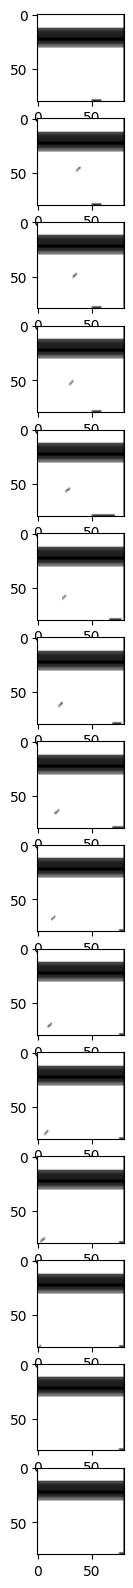

In [46]:
print(rewards[0:15].flatten().tolist())

fig, axs = plt.subplots(15, 1, figsize=(30, 20))

for i in range(15):
    axs[i].imshow(states[i][0], cmap="binary")

In [21]:
with torch.cuda.amp.autocast():
    actual = value_agent(states).gather(1, actions)

    with torch.no_grad():
        new_states = torch.roll(states, -1, 0)
        new_states[torch.tensor(steps)] = _states

        optimal = value_agent.parameter["gamma"] * _value_agent(new_states).max(1)[0].unsqueeze(1)
        optimal = rewards + optimal

    for step in steps:
        optimal[step] = rewards[step]

/Users/Mac/anaconda3/envs/spesialpensum/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


In [22]:
print(actual.shape, optimal.shape)

torch.Size([2073, 1]) torch.Size([2073, 1])


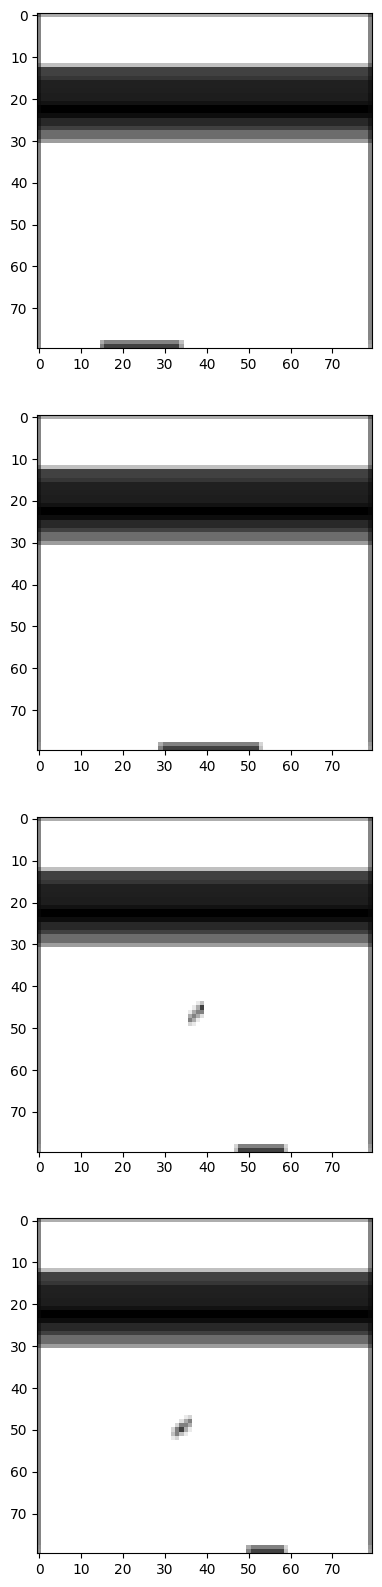

In [26]:
fig, axs = plt.subplots(4, 1, figsize=(30, 20))

for i in range(4):
    axs[i].imshow(states[5 + i][0], cmap="binary")